In [ ]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0))



CUDA Available: True
GPU Name: Tesla T4


In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
!pip install ultralytics


In [14]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
!ls "/content/drive/MyDrive/Aerial Object Guvi/extracted_dataset/"



test  train  valid


In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


In [17]:
import torch

In [18]:
# Main dataset folder
base_path = "/content/drive/MyDrive/Aerial Object Guvi/extracted_dataset/"

# Subfolders inside dataset
train_path = os.path.join(base_path, "train")
valid_path = os.path.join(base_path, "valid")
test_path  = os.path.join(base_path, "test")

print(train_path)
print(valid_path)
print(test_path)



/content/drive/MyDrive/Aerial Object Guvi/extracted_dataset/train
/content/drive/MyDrive/Aerial Object Guvi/extracted_dataset/valid
/content/drive/MyDrive/Aerial Object Guvi/extracted_dataset/test


In [19]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [20]:
# For Training (with augmentation)
train_gen = ImageDataGenerator(
    rescale=1./255,          # convert pixel values from 0–255 to 0–1
    rotation_range=20,       # random rotation
    width_shift_range=0.1,   # horizontal movement
    height_shift_range=0.1,  # vertical movement
    zoom_range=0.2,          # random zoom
    horizontal_flip=True     # flip image
)

# For Validation & Test (no augmentation)
test_gen = ImageDataGenerator(rescale=1./255)


In [21]:
train_data = train_gen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

valid_data = test_gen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_data = test_gen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 2662 images belonging to 2 classes.
Found 441 images belonging to 2 classes.
Found 215 images belonging to 2 classes.


In [ ]:
from tensorflow.keras import layers, models

# Create a simple CNN model
model = models.Sequential()

# 1st Convolution Block
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D(2, 2))

# 2nd Convolution Block
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))

# 3rd Convolution Block
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))

# Flatten layer (convert 2D output to 1D)
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))   # prevent overfitting

# Output layer (binary classification)
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


In [ ]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 49s 543ms/step - accuracy: 0.5740 - loss: 0.8417 - val_accuracy: 0.7415 - val_loss: 0.5669
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 43s 516ms/step - accuracy: 0.7213 - loss: 0.5562 - val_accuracy: 0.7029 - val_loss: 0.5820
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 43s 510ms/step - accuracy: 0.7333 - loss: 0.5236 - val_accuracy: 0.7234 - val_loss: 0.6297
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 43s 507ms/step - accuracy: 0.7698 - loss: 0.4686 - val_accuracy: 0.7778 - val_loss: 0.4672
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 42s 502ms/step - accuracy: 0.7943 - loss: 0.4576 - val_accuracy: 0.8073 - val_loss: 0.4446
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 43s 507ms/step - accuracy: 0.8049 - loss: 0.4199 - val_accuracy: 0.7846 - val_loss: 0.4481
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 42s 500ms/step - accuracy: 0.8112 - loss: 0.3981 - val_accuracy: 0.8118 - val_loss: 0.4325
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 42s 497ms/step - accuracy: 0.8002 - loss: 0.4395 - val_accu

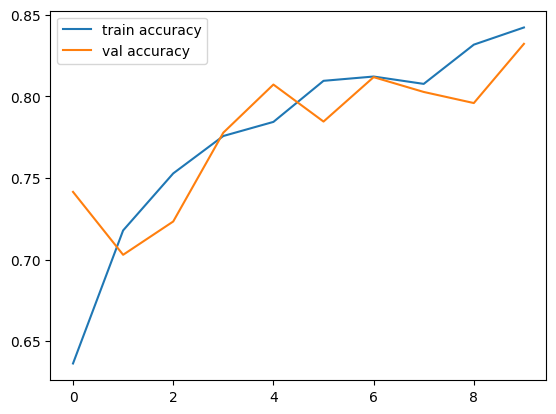

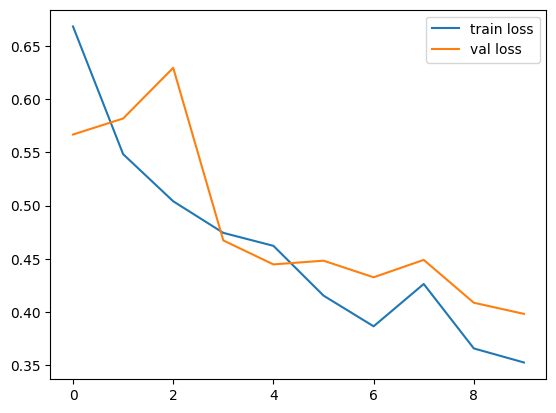

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.8288 - loss: 0.3779
Test Accuracy: 0.8372092843055725
Test Loss: 0.3578685224056244


In [ ]:
model.save('/content/drive/MyDrive/Aerial Object Guvi/my_model.keras')


In [22]:
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [11]:
# EfficientNetB0
base_eff = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)
base_eff.trainable = False

x = base_eff.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

eff_model = Model(inputs=base_eff.input, outputs=output)

eff_model.compile(
    optimizer=Adam(0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']

)

eff_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [12]:
history_eff = eff_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=15,
    callbacks=[early_stop]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 517s 6s/step - accuracy: 0.5295 - loss: 0.6965 - val_accuracy: 0.4898 - val_loss: 0.7022
Epoch 2/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 44s 523ms/step - accuracy: 0.4944 - loss: 0.6982 - val_accuracy: 0.4898 - val_loss: 0.7044
Epoch 3/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 44s 519ms/step - accuracy: 0.5269 - loss: 0.6947 - val_accuracy: 0.4898 - val_loss: 0.7041
Epoch 4/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 43s 517ms/step - accuracy: 0.5011 - loss: 0.6981 - val_accuracy: 0.4898 - val_loss: 0.6935
Epoch 5/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 44s 521ms/step - accuracy: 0.5100 - loss: 0.6951 - val_accuracy: 0.5102 - val_loss: 0.6927
Epoch 6/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 44s 523ms/step - accuracy: 0.4951 - loss: 0.6965 - val_accuracy: 0.4898 - val_loss: 0.7073
Epoch 7/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 44s 526ms/step - accuracy: 0.5076 - loss: 0.6986 - val_accuracy: 0.4898 - val_loss: 0.6933
Epoch 8/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 44s 518ms/step - accuracy: 0.5350 - loss: 0.6967 - val_accura

In [13]:
test_loss_eff, test_acc_eff = eff_model.evaluate(test_data)
print("EfficientNet Test Accuracy:", test_acc_eff)


7/7 ━━━━━━━━━━━━━━━━━━━━ 50s 7s/step - accuracy: 0.4274 - loss: 0.6943
EfficientNet Test Accuracy: 0.4372093081474304


In [14]:
eff_model.save("/content/drive/MyDrive/Aerial Object Guvi/efficientnet_model.keras")


In [ ]:
# MobileNetV2
base_mobile = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)
base_mobile.trainable = False

x = base_mobile.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

mobile_model = Model(inputs=base_mobile.input, outputs=output)

mobile_model.compile(
    optimizer=Adam(0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

mobile_model.summary()


Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history_mobile = mobile_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=15,
    callbacks=[early_stop]
)


Epoch 1/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 81s 800ms/step - accuracy: 0.7255 - loss: 0.5408 - val_accuracy: 0.9410 - val_loss: 0.1830
Epoch 2/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 546ms/step - accuracy: 0.9172 - loss: 0.2165 - val_accuracy: 0.9592 - val_loss: 0.1245
Epoch 3/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 44s 521ms/step - accuracy: 0.9423 - loss: 0.1652 - val_accuracy: 0.9637 - val_loss: 0.1097
Epoch 4/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 43s 517ms/step - accuracy: 0.9562 - loss: 0.1221 - val_accuracy: 0.9728 - val_loss: 0.0926
Epoch 5/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 44s 520ms/step - accuracy: 0.9597 - loss: 0.1167 - val_accuracy: 0.9705 - val_loss: 0.0912
Epoch 6/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 45s 532ms/step - accuracy: 0.9639 - loss: 0.1017 - val_accuracy: 0.9728 - val_loss: 0.0846
Epoch 7/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 43s 514ms/step - accuracy: 0.9723 - loss: 0.0747 - val_accuracy: 0.9705 - val_loss: 0.0823
Epoch 8/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 43s 513ms/step - accuracy: 0.9714 - loss: 0.0865 - val_accu

In [ ]:
test_loss_mobile, test_acc_mobile = mobile_model.evaluate(test_data)
print("MobileNet Test Accuracy:", test_acc_mobile)


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9607 - loss: 0.0933
MobileNet Test Accuracy: 0.9767441749572754


In [ ]:
mobile_model.save("/content/drive/MyDrive/Aerial Object Guvi/mobilenet_model.keras")


In [ ]:
# ResNet50
base_res = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)
base_res.trainable = False

x = base_res.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

res_model = Model(inputs=base_res.input, outputs=output)

res_model.compile(
    optimizer=Adam(0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

res_model.summary()


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_11[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history_res = res_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=15,
    callbacks=[early_stop]
)


Epoch 1/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 70s 681ms/step - accuracy: 0.5483 - loss: 0.7305 - val_accuracy: 0.6304 - val_loss: 0.6469
Epoch 2/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 44s 520ms/step - accuracy: 0.5962 - loss: 0.6730 - val_accuracy: 0.6145 - val_loss: 0.6409
Epoch 3/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 44s 520ms/step - accuracy: 0.6194 - loss: 0.6513 - val_accuracy: 0.6213 - val_loss: 0.6374
Epoch 4/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 44s 520ms/step - accuracy: 0.6301 - loss: 0.6438 - val_accuracy: 0.6122 - val_loss: 0.6605
Epoch 5/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 43s 516ms/step - accuracy: 0.6294 - loss: 0.6498 - val_accuracy: 0.6485 - val_loss: 0.6185
Epoch 6/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 44s 527ms/step - accuracy: 0.6295 - loss: 0.6347 - val_accuracy: 0.6576 - val_loss: 0.6167
Epoch 7/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 45s 544ms/step - accuracy: 0.6564 - loss: 0.6303 - val_accuracy: 0.6372 - val_loss: 0.6238
Epoch 8/15
84/84 ━━━━━━━━━━━━━━━━━━━━ 44s 520ms/step - accuracy: 0.6559 - loss: 0.6277 - val_accu

In [ ]:
test_loss_res, test_acc_res = res_model.evaluate(test_data)
print("ResNet Test Accuracy:", test_acc_res)


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 749ms/step - accuracy: 0.7337 - loss: 0.5376
ResNet Test Accuracy: 0.7302325367927551


In [ ]:
res_model.save("/content/drive/MyDrive/Aerial Object Guvi/resnet_model.keras")


In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [25]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.load_model('/content/drive/MyDrive/Aerial Object Guvi/my_model.keras')
eff_model = keras.models.load_model('/content/drive/MyDrive/Aerial Object Guvi/efficientnet_model.keras')
mobile_model = keras.models.load_model('/content/drive/MyDrive/Aerial Object Guvi/mobilenet_model.keras')
res_model = keras.models.load_model('/content/drive/MyDrive/Aerial Object Guvi/resnet_model.keras')


In [29]:
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_pre

eff_test_gen = ImageDataGenerator(preprocessing_function=eff_pre)

eff_test_data = eff_test_gen.flow_from_directory(
    test_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 215 images belonging to 2 classes.


In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_model(model, test_data):
    preds = model.predict(test_data)
    preds_binary = (preds > 0.5).astype("int32").flatten()
    true_labels = test_data.classes

    print("\nClassification Report:")
    print(classification_report(true_labels, preds_binary))

    cm = confusion_matrix(true_labels, preds_binary)
    print("\nConfusion Matrix:")
    print(cm)
    return preds_binary, cm


In [31]:
print("Custom CNN Model:")
pred_model, cm1 = evaluate_model(model, test_data)

print("EfficientNet:")
pred_eff, cm2 = evaluate_model(eff_model, eff_test_data)

print("MobileNet:")
pred_mobile, cm3 = evaluate_model(mobile_model, test_data)

print("ResNet:")
pred_res, cm4 = evaluate_model(res_model, test_data)


Custom CNN Model:
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.86       121
           1       0.87      0.73      0.80        94

    accuracy                           0.84       215
   macro avg       0.84      0.83      0.83       215
weighted avg       0.84      0.84      0.83       215


Confusion Matrix:
[[111  10]
 [ 25  69]]
EfficientNet:


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 138s 20s/step

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.36      0.41       121
           1       0.37      0.48      0.42        94

    accuracy                           0.41       215
   macro avg       0.42      0.42      0.41       215
weighted avg       0.43      0.41      0.41       215


Confusion Matrix:
[[44 77]
 [49 45]]
MobileNet:
7/7 ━━━━━━━━━━━━━━━━━━━━ 94s 13s/step

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       121
           1       0.99      0.96      0.97        94

    accuracy                           0.98       215
   macro avg       0.98      0.97      0.98       215
weighted avg       0.98      0.98      0.98       215


Confusion Matrix:
[[120   1]
 [  4  90]]
ResNet:
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step

Classification Report:
              precision    recall  f1-score   support

      

In [32]:
mobile_model.save("/content/drive/MyDrive/Aerial Object Guvi/best_model_mobilenet.keras")


In [34]:
best_model = keras.models.load_model("/content/drive/MyDrive/Aerial Object Guvi/best_model_mobilenet.keras")


In [35]:
print("Best Model:")
best_pred_model, best_cm = evaluate_model(best_model, test_data)

Best Model:
7/7 ━━━━━━━━━━━━━━━━━━━━ 105s 14s/step

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       121
           1       0.99      0.96      0.97        94

    accuracy                           0.98       215
   macro avg       0.98      0.97      0.98       215
weighted avg       0.98      0.98      0.98       215


Confusion Matrix:
[[120   1]
 [  4  90]]


In [39]:
full_test_data = test_gen.flow_from_directory(
    test_path,
    target_size=(224,224),
    batch_size=215,
    class_mode='binary',
    shuffle=False
)


Found 215 images belonging to 2 classes.


In [47]:
import matplotlib.pyplot as plt
import numpy as np
import random

def simple_visualize(model, test_data, num_each=10):

    # One batch containing ALL Bird + ALL Drone
    images, labels = next(test_data)

    # Get indices
    bird_idx  = [i for i, l in enumerate(labels) if l == 0]
    drone_idx = [i for i, l in enumerate(labels) if l == 1]

    # Choose samples
    chosen = random.sample(bird_idx, num_each) + random.sample(drone_idx, num_each)

    chosen_images = images[chosen]
    chosen_labels = labels[chosen]

    # Predict
    preds = model.predict(chosen_images)
    preds_bin = (preds > 0.5).astype("int32").flatten()

    # Show
    plt.figure(figsize=(12,12))
    for i, idx in enumerate(chosen):
        plt.subplot(5,4,i+1)
        plt.imshow(images[idx])

        actual = "Bird" if labels[idx] == 0 else "Drone"
        pred   = "Bird" if preds_bin[i] == 0 else "Drone"

        plt.title(f"Pred: {pred}\nActual: {actual}", fontsize=9)
        plt.axis("off")

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


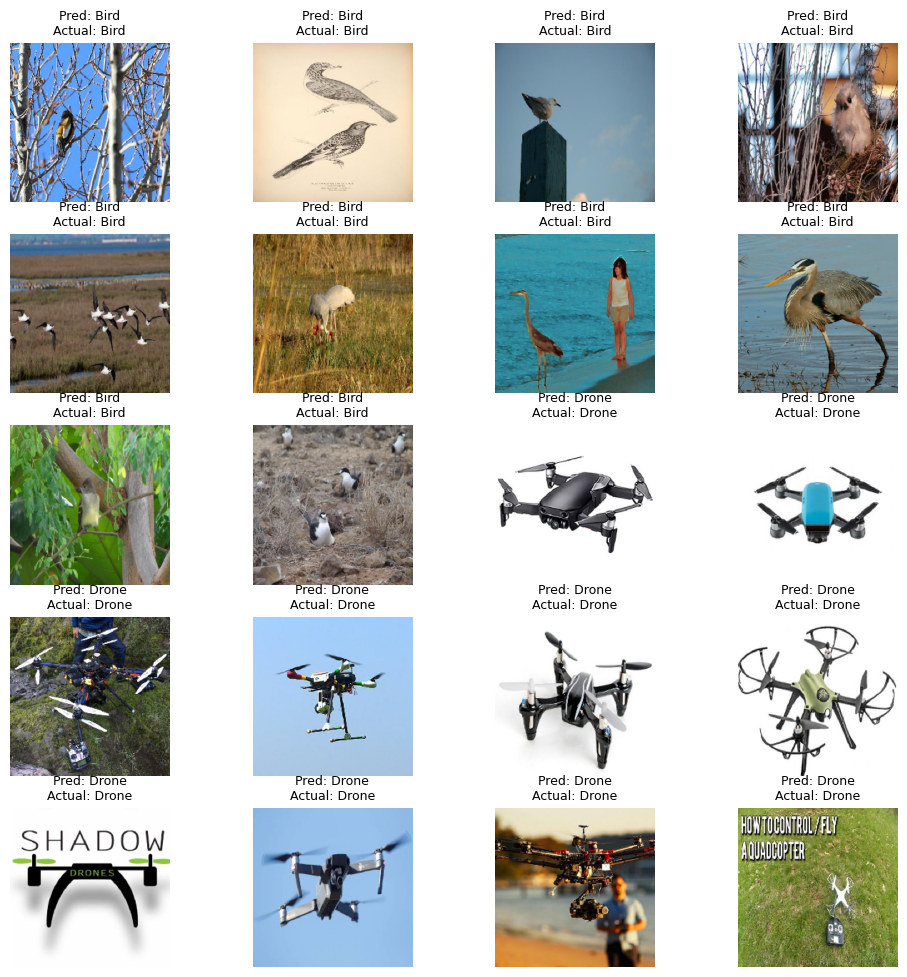

In [48]:
simple_visualize(best_model, full_test_data, num_each=10)
